In [1]:
# Import libs
import sys
sys.path
sys.path.append('../service/')

import random
import copy

import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import gempy as gp
from gempy.utils import section_utils

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Init geo_model

In [2]:
# instantiate the geo_model
geo_model = gp.create_model("BaseModel")

# defautl data
geo_model = gp.init_data(
    geo_model,
    extent=[0, 1000, 0, 1000, 0, 1000],
    resolution=[10, 10, 10]
)

# compile theno function
gp.set_interpolation_data(
    geo_model,
    compile_theano=True,
    theano_optimizer='fast_run',
)

Active grids: ['regular']
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range            1732.05
$C_o$            71428.6
drift equations      [3]


## Define Configuration Functions

In [3]:
def set_congiguration(geo_model, geo_model_extent, section):
        
    # Set extent  
    # Fix for Bug  # Replace with geo_model.set_extent(extent=extent)
    gp.init_data(
        geo_model,
        extent=geo_model_extent,
        resolution=[10, 10, 10]
    )
    
    # Set grids
    section_dict = {'section': (
        section['p1'],
        section['p2'],
        section['resolution']
    )}
    geo_model.set_section_grid(section_dict=section_dict)
    # geo_model.set_active_grid(grid_name=['sections'], reset=True)

## Definde Topology Functions

In [4]:
def update_series(geo_model, series_df):
    """Updates series of the geo-model to the one stored in data.
    
    Loops over series and appends missing ones and removes obsolet ones.
    
    Args:
        geo_model = The geo_model
        series_df: DataFrame = containing series data
    """

    # Get currently stored series data
    series_old = list(geo_model.series.df.to_dict()['order_series'].keys())

    # add new series
    for index, row in series_df.iterrows():

        serie_name = row['name']
        if serie_name not in series_old:

            geo_model.add_series(series_list=[serie_name])

    # remove obsolete series
    for serie in series_old:

        if serie not in series_df['name'].to_list():

            geo_model.delete_series(serie)

In [5]:
def update_faults_relations(geo_model, series_df):
    """Sets fault relations.
    
    Sets isfault property of surfaceses accordingly.
    
    Args:
        geo_model = The geo_model
        series_df: DataFrame = containing series data    
    """

    for index, row in series_df.iterrows():

        serie_name = row['name']
        serie_isfault = row['isfault']
        if serie_isfault:

            geo_model.set_is_fault([serie_name])

In [6]:
def update_surfaces(geo_model, surfaces_df):
    """Updates surfaces of the geo-model to the one stored in data.
    
    Adds missing surfaces and removes obsolet ones.

    Args:
        geo_model = The geo_model
        series_df: DataFrame = containing surface data
    """
    
    # Getting current surface data
    surfaces_old = geo_model.surfaces.df['surface'].to_list()

    # add and update surfaces
    for index, row in surfaces_df.iterrows():

        surface_name = row['name']
        surface_serie = row['serie']
        if surface_name not in surfaces_old:

            geo_model.add_surfaces(surface_list=[surface_name])
            gp.map_series_to_surfaces(
                geo_model,
                {surface_serie: surface_name}
            )

        else:

            gp.map_series_to_surfaces(
                geo_model,
                {surface_serie: surface_name}
            )

    # remove obsolete surfaces
    for surface in surfaces_old:

        if surface not in surfaces_df['name'].to_list():

            geo_model.delete_surfaces(surface)

In [7]:
def set_topology(geo_model, series_df, surfaces_df):
    
    # Topoligical Realtionships
    update_series(geo_model=geo_model, series_df=series_df)
    update_surfaces(geo_model=geo_model, surfaces_df=surfaces_df)
    update_faults_relations(geo_model=geo_model, series_df=series_df)

## Definde Main Functions

In [1]:
geo_model_extent = [0,2000,0,2000,0,2000]
section = {
    'p1': [0, 1000],
    'p2': [2000, 1000],
    'resolution': [200, 200]
}

series_df = pd.read_csv('./data/simple_fault_model_series.csv')
surfaces_df = pd.read_csv('./data/simple_fault_model_surfaces.csv')

surface_points_input_data = pd.read_csv('./data/simple_fault_model_points.csv')
orientaions_input_data = pd.read_csv('./data/simple_fault_model_orientations.csv')

# Format geological_input_data
surface_points_original_df = surface_points_input_data[['X', 'Y', 'Z', 'formation']]

# rename colums
surface_points_original_df.columns = ['X', 'Y', 'Z', 'surface']

# add distribution type and parameter
surface_points_original_df['param1'] = 10

# Orientaions
orientations_original_df = orientaions_input_data[['X', 'Y', 'Z', 'dip', 'azimuth', 'polarity', 'formation']]

NameError: name 'pd' is not defined

In [10]:
def set_singel_realization(
    geo_model,
    geo_model_extent,
    section,
    series_df,
    surfaces_df,
    surface_points_df,
    orientations_df
):
    
    set_congiguration(geo_model=geo_model, geo_model_extent=geo_model_extent, section=section)
    set_topology(geo_model=geo_model, series_df=series_df, surfaces_df=surfaces_df)
    geo_model.set_surface_points(surface_points_df, update_surfaces=False)
    geo_model.set_orientations(orientations_original_df, update_surfaces=False)
    geo_model.update_to_interpolator()

In [11]:
def check_setup_single_realization():
    
    # check if surface_points are within geo-model-extent
    current_extent = geo_model.grid.regular_grid.extent
    if not (
        current_extent[0] <= np.min(geo_model.surface_points.df['X'].values) and
        current_extent[1] >= np.max(geo_model.surface_points.df['X'].values) and
        current_extent[2] <= np.min(geo_model.surface_points.df['Y'].values) and
        current_extent[3] >= np.max(geo_model.surface_points.df['Y'].values) and
        current_extent[4] <= np.min(geo_model.surface_points.df['Z'].values) and
        current_extent[5] >= np.max(geo_model.surface_points.df['Z'].values)
    ):
        raise ValueError(f'Some surface-poins are not within geo-model-extent-bounds')
        
    # check if orientations are within geo-model-extent
    if not (
        current_extent[0] <= np.min(geo_model.orientations.df['X'].values) and
        current_extent[1] >= np.max(geo_model.orientations.df['X'].values) and
        current_extent[2] <= np.min(geo_model.orientations.df['Y'].values) and
        current_extent[3] >= np.max(geo_model.orientations.df['Y'].values) and
        current_extent[4] <= np.min(geo_model.orientations.df['Z'].values) and
        current_extent[5] >= np.max(geo_model.orientations.df['Z'].values)
    ):
        raise ValueError(f'Some orientations are not within geo-model-extent-bounds')
    
    # check if at least one orientaion per series
    orientation_series = geo_model.orientations.df['series'].unique()
    geo_model_series = list(geo_model.series.df.index)
    if not all([serie in geo_model_series for serie in orientation_series]):
        
        raise ValueError(f'Some series have no orientaion')
    
    
    # check if at least two surface-points per surface
    surfaces_surface_points = geo_model.surface_points.df
    surfaces_geo_model = list(geo_model.surfaces.df['surface'])
    for surface in surfaces_geo_model:

        if not surface == 'basement':
            len_df = len(surfaces_surface_points[surfaces_surface_points['surface'] == surface])
            if len_df < 2:

                raise ValueError(f'Each surface needs at least 2 surface points.')

In [12]:
set_singel_realization(
    geo_model=geo_model,
    geo_model_extent=geo_model_extent,
    section=section,
    series_df=series_df,
    surfaces_df=surfaces_df,
    surface_points_df=surface_points_original_df,
    orientations_df=orientations_original_df    
)

Active grids: ['regular']
Active grids: ['regular' 'sections']
Fault colors changed. If you do not like this behavior, set change_color to False.


In [13]:
check_setup_single_realization()

In [14]:
solution = gp.compute_model(model=geo_model)
solution = gp.compute_model(model=geo_model)

/home/stefan/coding/gempy/gempy/core/solution.py:196: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, simplices, normals, values = measure.marching_cubes_lewiner(


/home/stefan/coding/gempy/gempy/plot/visualization_2d.py:208: UserWarning: the orientations are not converted to apparent dip.
  warnings.warn('the orientations are not converted to apparent dip.')


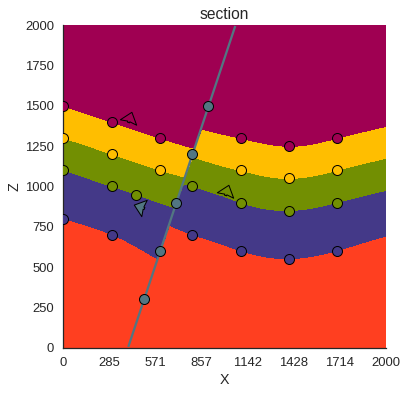

In [15]:
gp.plot.plot_section_by_name(geo_model, 'section')

## UQ extension

In [16]:
# Set single realization as base
set_singel_realization(
    geo_model=geo_model,
    geo_model_extent=geo_model_extent,
    section=section,
    series_df=series_df,
    surfaces_df=surfaces_df,
    surface_points_df=surface_points_original_df,
    orientations_df=orientations_original_df    
)

Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
Fault colors changed. If you do not like this behavior, set change_color to False.


In [17]:
def manipulate_surface_points_inplace(surface_points_copy, surface_points_original_df):
    """Manipulates the surface_points_copy dataframe.
    
        Samples X, Y, Z values form the original DataFrame and thier
        respective distribution types and parameters.\
        Potential update:
            - Sampling parameter per axis i.e. param1_x, param1_y, ...
            - Diffenrent sampling types i.e. normal, uniformal, ...
    
        Args:
            surface_points_copy: DataFrame = copy of the original geological
                input data surface-points DataFrame.
            surface_points_original_df: DataFrame = original geological input data
                surface-points DataFrame.
    """
    
    surface_points_copy['X'] = ss.norm.rvs(
        loc=surface_points_original_df['X'].values,
        scale=surface_points_original_df['param1'].values)
    surface_points_copy['Y'] = ss.norm.rvs(
        loc=surface_points_original_df['Y'].values,
        scale=surface_points_original_df['param1'].values)
    surface_points_copy['Z'] = ss.norm.rvs(
        loc=surface_points_original_df['Z'].values,
        scale=surface_points_original_df['param1'].values) 

In [18]:
def run_realizations(
    geo_model,
    n_realizations,
    surface_points_original_df,
    orientations_original_df,
    section
):
    """Runs x ralizations"""

    # Copy geological input data to manipulate per realization.
    surface_points_copy = copy.deepcopy(surface_points_original_df)

    # Storage for calucalted ralizations
    list_section_data = []

    # Calculate realizations
    for i in range(n_realizations):

        print(f'Realization: {i}')
        
        # manipulate surface_points_copy in place
        manipulate_surface_points_inplace(
            surface_points_copy=surface_points_copy,
            surface_points_original_df=surface_points_original_df)
        
        # Set manipulated surface points
        geo_model.set_surface_points(surface_points_copy, update_surfaces=False)
        # geo_model.set_orientations(orientations_original_df, update_surfaces=False)

        # update to interpolator
        geo_model.update_to_interpolator()

        # Compute solution
        # TODO: Fix bug!
        # till here: until 90.1 ms for 1 realizations
        # 213 m with 2x gp.compute_model()
        try:
            solution = gp.compute_model(model=geo_model)
            solution = gp.compute_model(model=geo_model)
            # gp.plot.plot_section_by_name(geo_model, 'section')
        except ValueError as err:
            print('ValueError')
            # Append last working realization
            list_section_data.append(geo_model
                                     .solutions
                                     .sections[0][0]
                                     .reshape(section['resolution'])
                                     )

            
        # collect extracted section data
        list_section_data.append(geo_model
                                 .solutions
                                 .sections[0][0]
                                 .reshape(section['resolution'])
                                 )

    return list_section_data

In [19]:
def process_list_section_data(list_section_data):

    # Process results Stack results
    section_data_stack = np.round(np.dstack(list_section_data))

    # Get lithologies in stack
    lithology_ids = np.unique(section_data_stack)

    return section_data_stack, lithology_ids

In [20]:
def count_lithology_occurrences_over_realizations(
        section_data_stack,
        lithology_ids,
        section
):
    
    count_array = np.empty((
        section['resolution'][0],
        section['resolution'][1],
        len(lithology_ids)))

    for index, lithology in enumerate(lithology_ids):

        count_array[:, :, index] = np.sum((
            section_data_stack == lithology).astype(int), axis=2)

    return count_array

In [21]:
def calculate_information_entropy(count_array, n_realizations):

    # Calculate information entropy
    probability_array = count_array / n_realizations
    return ss.entropy(probability_array, axis=2)

In [22]:
# Constants
n_realizations = 10

# Run realizations
list_section_data = run_realizations(
    geo_model=geo_model,
    n_realizations=n_realizations,
    surface_points_original_df=surface_points_original_df,
    orientations_original_df=orientations_original_df,
    section=section
)

# Process output
section_data_stack, lithology_ids = process_list_section_data(
    list_section_data=list_section_data)

# Count occurrences
count_array = count_lithology_occurrences_over_realizations(
        section_data_stack=section_data_stack,
        lithology_ids=lithology_ids,
        section=section
)

# Calculate entrop
entropy_map = calculate_information_entropy(
    count_array=count_array, n_realizations=n_realizations)

Realization: 0
Realization: 1
Realization: 2
Realization: 3
Realization: 4
Realization: 5
Realization: 6
Realization: 7
Realization: 8
Realization: 9


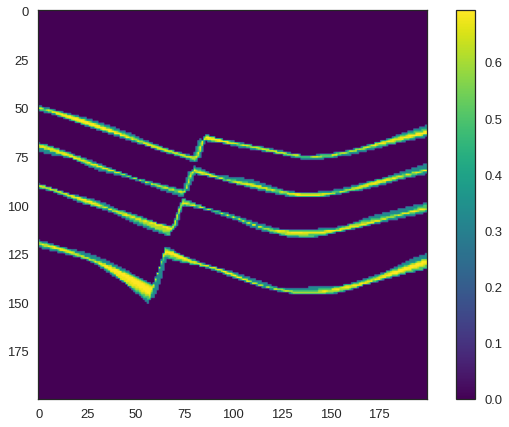

In [23]:
plt.imshow(entropy_map[:,::-1].T, cmap='viridis')
plt.colorbar()
plt.show()

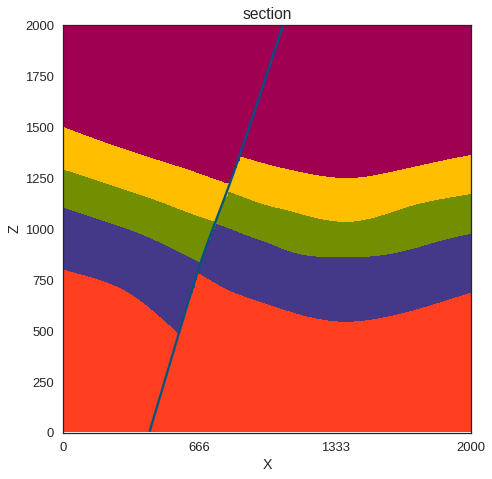

In [24]:
polygondict, cdict, extent = gp.utils.section_utils.get_polygon_dictionary(
    geo_model=geo_model,
    section_name="section"
)

In [25]:
keys = list(polygondict.keys())
polygons_dict = {}
# loop over rock units
for key in keys:

    # extract polygons of rock unit
    polygons = polygondict[key]
    # if polygons of rock unit present
    if polygons:

        # loop over plygons of rock unit i
        for index, polygon in enumerate(polygons):

            # Create a new dict entry of flatten coordiantes as list
            polygons_dict[f'{key}_{index}'] = polygon.flatten().tolist()

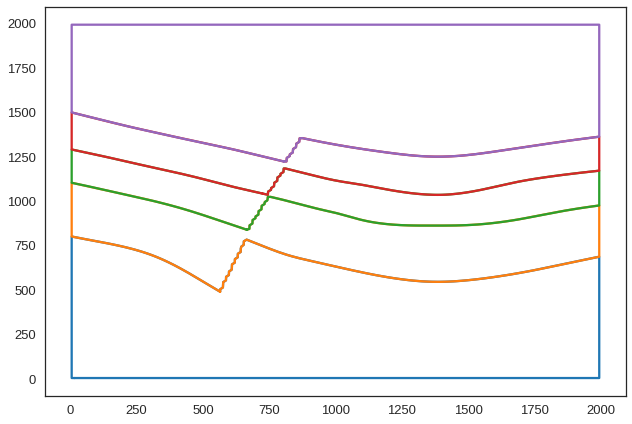

In [26]:
for key in polygons_dict.keys():
    
    plt.plot(
        polygons_dict[key][0::2],
        polygons_dict[key][1::2],
    )
    
plt.show()

In [27]:
geo_model.series.df.index.to_list()

['Fault_Series', 'Strat_Series']

In [28]:
geo_model.surfaces.df['surface']

0     Main_Fault
1    Sandstone_2
2      Siltstone
3          Shale
4    Sandstone_1
5       basement
Name: surface, dtype: object